In [28]:
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re, copy
import numpy as np
from collections import Counter
from operator import itemgetter
import plotly.plotly as py
from sklearn.preprocessing import Imputer
import math
import pickle
import time
import sys
from scipy.spatial.distance import cosine
import datetime
from fancyimpute import NuclearNormMinimization
from fancyimpute import MICE
from IPython.display import Image
from IPython.core.display import display, HTML

# Load data

## Jobs Data

In [29]:
jobs = pd.read_csv('data/jumpman_jobs.csv', dtype={'date_created': str})
print ('jobs.shape: ', jobs.shape, '\n jobs.columns', jobs.columns)
jobs.describe()

jobs.shape:  (20257, 11) 
 jobs.columns Index(['job_uuid', 'date_created', 'courier_uuid', 'purchase_price',
       'pip_account_id', 'business_name', 'street_address_1',
       'street_address_2', 'city', 'state', 'zip_code'],
      dtype='object')


,purchase_price,pip_account_id
count,20257.000000,20257.000000
mean,28.555533,80635.983808
std,33.554349,26854.941140
min,0.000000,8363.000000
25%,12.150000,62051.000000
50%,20.000000,88266.000000
75%,34.040000,101576.000000
max,1471.230000,122988.000000


## Pip Data

pip.shape:  (19453, 7) 
 pip.columns Index(['transaction_id', 'transaction_dt', 'category', 'description', 'amount',
       'transaction_code', 'pip_account_id'],
      dtype='object')
       transaction_id        amount  transaction_code  pip_account_id
count    1.945300e+04  19453.000000      19453.000000    19453.000000
mean     4.557958e+06    -28.019777       1300.039069    80825.005500
std      9.419861e+04     35.111613          0.883111    26829.943309
min      4.359866e+06  -1471.230000       1300.000000     8363.000000
25%      4.477995e+06    -33.560000       1300.000000    62051.000000
50%      4.560621e+06    -19.620000       1300.000000    88681.000000
75%      4.636049e+06    -11.900000       1300.000000   101608.000000
max      5.183503e+06   1662.250000       1320.000000   122988.000000


//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



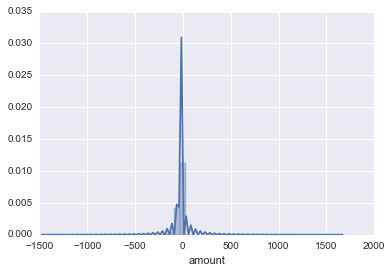

In [30]:
pip = pd.read_csv('data/jumpman_pip.csv', dtype={'transaction_dt': str})
print ('pip.shape: ', pip.shape, '\n pip.columns', pip.columns)
print (pip.describe())
sns.distplot(pip.amount)

# Let's convert the timestamps to epoch

In [31]:
job_pattern = '%Y-%m-%d %H:%M:%S.%f'
pip_pattern = '%Y-%m-%d %H:%M:%S'
start = time.time()
jobs['job_epoch'] = [int(time.mktime(time.strptime(x, job_pattern))) for x in jobs.date_created]
pip['pip_epoch'] = [int(time.mktime(time.strptime(x, pip_pattern))) for x in pip.transaction_dt]
end = time.time()
print('Too slow? These conversions took', round(end - start,2), 'seconds')

Too slow? These conversions took 1.08 seconds


# Let's build some simple NLP feature to compare business_name with description

In [32]:
# Build a dictionary
index_word = {}
word_index = {}
word_count = 0
for text in jobs.business_name:
    if type(text) is str:
        for word in text.lower().split(' '):
            if word not in word_index:
                index_word[word_count] = word
                word_index[word] = word_count
                word_count+=1
for text in pip.description:
    if type(text) is str:
        for word in text.lower().split(' '):
            if word not in word_index:
                index_word[word_count] = word
                word_index[word] = word_count
                word_count+=1

print (len(index_word), len(word_index))

4948 4948


# Build unigram feature vectors

In [33]:
unigram_bus_nm_list = []
for row in range(jobs.shape[0]):
    text = jobs.iloc[row].business_name
    if type(text) is str:
        ug = [0] * len(index_word)
        for word in text.lower().split(' '):
            ug[word_index[word]] = 1
        unigram_bus_nm_list.append([ug])
jobs = pd.concat([jobs, pd.DataFrame(unigram_bus_nm_list)], axis=1)
print (jobs.shape)
print (jobs.head())

unigram_desc_list = []
for row in range(pip.shape[0]):
    text = pip.iloc[row].description
    if type(text) is str:
        ug = [0] * len(index_word)
        for word in text.lower().split(' '):
            if type(word) is str:
                ug[word_index[word]] = 1
        unigram_desc_list.append([ug])
pip = pd.concat([pip, pd.DataFrame(unigram_desc_list)], axis=1)
print (pip.shape)
print (pip.head())

(20257, 13)
                               job_uuid                date_created  \
0  55ff57fe-83d1-471c-bba8-444106f6a432  2015-11-02 22:48:00.765227   
1  cb7076ed-88e7-4098-8c8b-6db984623188   2015-11-03 00:09:51.26556   
2  fb86438f-8952-4398-8e5c-f509338f1851  2015-11-03 01:38:14.457542   
3  eff38a8e-6b32-477c-9515-7f698c242048  2015-11-03 01:58:25.297675   
4  6a3f469e-eb6b-4ae9-b2ed-b40f2217c3d3  2015-11-03 02:19:12.072772   

                           courier_uuid  purchase_price  pip_account_id  \
0  1da6fc9d-b192-46a6-971a-429d94ac333c           11.94            8363   
1  1da6fc9d-b192-46a6-971a-429d94ac333c          541.73            8363   
2  1da6fc9d-b192-46a6-971a-429d94ac333c           49.32            8363   
3  1da6fc9d-b192-46a6-971a-429d94ac333c            7.20            8363   
4  1da6fc9d-b192-46a6-971a-429d94ac333c           46.16            8363   

           business_name      street_address_1 street_address_2  \
0          Il Tramezzino        454 N Canon

## Join on pip_account_id
This will result in a cross-product containing all possible matches

In [35]:
jobs_pip = pd.merge(jobs, pip, how='outer', on=['pip_account_id'])
print ('jobs_pip.shape: ', jobs_pip.shape)
jobs_pip.head(n=5)

jobs_pip.shape:  (1449299, 21)


,job_uuid,date_created,courier_uuid,purchase_price,pip_account_id,business_name,street_address_1,street_address_2,city,state,...,job_epoch,0_x,transaction_id,transaction_dt,category,description,amount,transaction_code,pip_epoch,0_y
0,55ff57fe-83d1-471c-bba8-444106f6a432,2015-11-02 22:48:00.765227,1da6fc9d-b192-46a6-971a-429d94ac333c,11.94,8363.0,Il Tramezzino,454 N Canon Dr,NaN,Beverly Hills,CA,...,1.446522e+09,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4435552.0,2015-11-03 00:24:47,Retail Stores,"APPLE STORE #R124, LOS ANGELES, CA",-200.00,1300.0,1.446528e+09,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,55ff57fe-83d1-471c-bba8-444106f6a432,2015-11-02 22:48:00.765227,1da6fc9d-b192-46a6-971a-429d94ac333c,11.94,8363.0,Il Tramezzino,454 N Canon Dr,NaN,Beverly Hills,CA,...,1.446522e+09,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4435551.0,2015-11-03 00:40:03,Retail Stores,"APPLE STORE #R124, LOS ANGELES, CA",-341.73,1300.0,1.446529e+09,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,55ff57fe-83d1-471c-bba8-444106f6a432,2015-11-02 22:48:00.765227,1da6fc9d-b192-46a6-971a-429d94ac333c,11.94,8363.0,Il Tramezzino,454 N Canon Dr,NaN,Beverly Hills,CA,...,1.446522e+09,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4440375.0,2015-11-03 01:55:04,Restaurants,"FISH GRILL, LOS ANGELES, CA",-49.32,1300.0,1.446534e+09,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,55ff57fe-83d1-471c-bba8-444106f6a432,2015-11-02 22:48:00.765227,1da6fc9d-b192-46a6-971a-429d94ac333c,11.94,8363.0,Il Tramezzino,454 N Canon Dr,NaN,Beverly Hills,CA,...,1.446522e+09,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4428301.0,2015-11-03 02:09:43,Restaurants,"NOBU LA, WEST HOLLYWOO, CA",-236.53,1300.0,1.446535e+09,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,55ff57fe-83d1-471c-bba8-444106f6a432,2015-11-02 22:48:00.765227,1da6fc9d-b192-46a6-971a-429d94ac333c,11.94,8363.0,Il Tramezzino,454 N Canon Dr,NaN,Beverly Hills,CA,...,1.446522e+09,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4428299.0,2015-11-03 02:14:46,Restaurants,"NOBU LA, WEST HOLLYWOO, CA",-15.26,1300.0,1.446535e+09,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# Let's remove jobs with no potential matches
Those in which the pip_account_id did not match a record. There are 64 records in the Pip data without a potential row in the jobs data base solely on pip_account_id.

### Remove the orphan jobs

In [37]:
jobs_pip = jobs_pip[pd.isnull(jobs_pip.transaction_dt) == False]
print ('jobs_pip.shape: ', jobs_pip.shape)

jobs_pip.shape:  (1449237, 21)


# Assumption: The timezones between jobs.date_created and pip.date_created are the same
# Assumption: The timestamp in a pip transaction record must be later than the timestamp in the jobs records.  
This could potentially be a faulty assumption if the timestamps are not recorded as expected.  Some system might write a transaction to the logs some time after the event actually occured.  However, it seems reasonable to assume the timestamps are meaningful.

In [38]:
jobs_pip = jobs_pip[jobs_pip.job_epoch < jobs_pip.pip_epoch]
jobs_pip.shape

(755513, 21)

## Assumption: Pip transactions will occur withing X hours of the job timestamp.
Let's begin with 24 hours

In [39]:
jobs_pip = jobs_pip[jobs_pip.job_epoch + 24*60*60 > jobs_pip.pip_epoch]
print ('jobs_pip.shape: ', jobs_pip.shape)

jobs_pip.shape:  (145242, 21)


# Add the restriction that pip.amount must be within 25% of jobs.purchase_price

In [40]:
jobs_pip = jobs_pip[(jobs_pip.purchase_price + jobs_pip.amount >= -jobs_pip.purchase_price * 0.25)]
print ('jobs_pip.shape: ', jobs_pip.shape)
jobs_pip.head()

jobs_pip.shape:  (95305, 21)


,job_uuid,date_created,courier_uuid,purchase_price,pip_account_id,business_name,street_address_1,street_address_2,city,state,...,job_epoch,0_x,transaction_id,transaction_dt,category,description,amount,transaction_code,pip_epoch,0_y
5,55ff57fe-83d1-471c-bba8-444106f6a432,2015-11-02 22:48:00.765227,1da6fc9d-b192-46a6-971a-429d94ac333c,11.94,8363.0,Il Tramezzino,454 N Canon Dr,NaN,Beverly Hills,CA,...,1.446522e+09,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4443152.0,2015-11-03 02:25:42,Restaurants,"STARBUCKS #05758 BEVERLY, Beverly Hills, CA",-7.20,1300.0,1.446536e+09,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
10,55ff57fe-83d1-471c-bba8-444106f6a432,2015-11-02 22:48:00.765227,1da6fc9d-b192-46a6-971a-429d94ac333c,11.94,8363.0,Il Tramezzino,454 N Canon Dr,NaN,Beverly Hills,CA,...,1.446522e+09,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4438164.0,2015-11-03 04:28:49,Restaurants,"PHONOMENAL, WEST HOLLYWOO, CA",-10.96,1300.0,1.446543e+09,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
11,55ff57fe-83d1-471c-bba8-444106f6a432,2015-11-02 22:48:00.765227,1da6fc9d-b192-46a6-971a-429d94ac333c,11.94,8363.0,Il Tramezzino,454 N Canon Dr,NaN,Beverly Hills,CA,...,1.446522e+09,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4455065.0,2015-11-03 19:42:27,Restaurants,"CABBAGE PATCH - BEVERL, BEVERLY HILLS, CA",-14.17,1300.0,1.446598e+09,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
17,55ff57fe-83d1-471c-bba8-444106f6a432,2015-11-02 22:48:00.765227,1da6fc9d-b192-46a6-971a-429d94ac333c,11.94,8363.0,Il Tramezzino,454 N Canon Dr,NaN,Beverly Hills,CA,...,1.446522e+09,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4461227.0,2015-11-03 22:40:32,Restaurants,"TENDER GREENS CULVER C, CULVER CITY, CA",-11.95,1300.0,1.446608e+09,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
60,cb7076ed-88e7-4098-8c8b-6db984623188,2015-11-03 00:09:51.26556,1da6fc9d-b192-46a6-971a-429d94ac333c,541.73,8363.0,Apple Store,8500 Beverly Blvd,NaN,Los Angeles,CA,...,1.446527e+09,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4435552.0,2015-11-03 00:24:47,Retail Stores,"APPLE STORE #R124, LOS ANGELES, CA",-200.00,1300.0,1.446528e+09,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# Compute the simmilarity between the unigram vectors

In [41]:
# Cosine sim was slow, just counting common words
def common_elements(list1, list2):
    result = 0
    try:
        if len(list1) == len(list2):
            for i,element1 in enumerate(list1):
                if element1 == 1 and element1 == list2[i]:
                    result+=1
    except:
        #print ("Something about the lists is wrong:", sys.exc_info()[0])
        pass
    return result

jobs_pip['sim'] = jobs_pip.transpose().apply(lambda x: common_elements(x['0_x'], x['0_y']))
jobs_pip.describe()

,purchase_price,pip_account_id,job_epoch,transaction_id,amount,transaction_code,pip_epoch,sim
count,95305.000000,95305.000000,9.530500e+04,9.530500e+04,95305.000000,95305.0,9.530500e+04,95305.000000
mean,36.196606,81045.433629,1.447018e+09,4.559209e+06,-19.303388,1300.0,1.447048e+09,0.036441
std,38.914667,26717.877924,3.720078e+05,9.255152e+04,18.890264,0.0,3.727519e+05,0.231701
min,0.070000,8363.000000,1.446350e+09,4.359866e+06,-1471.230000,1300.0,1.446351e+09,0.000000
25%,16.790000,62051.000000,1.446693e+09,4.482055e+06,-23.370000,1300.0,1.446710e+09,0.000000
50%,26.690000,89066.000000,1.447036e+09,4.557693e+06,-14.700000,1300.0,1.447054e+09,0.000000
75%,41.800000,101576.000000,1.447318e+09,4.634703e+06,-9.810000,1300.0,1.447374e+09,0.000000
max,1471.230000,122988.000000,1.447650e+09,4.985265e+06,-0.070000,1300.0,1.447650e+09,4.000000


# We still need to drop over 70k transactions
Let's look at the distribution of purchase_price + amount.  If the purchase_price is significantly less than the amount charged, it's likely not a match

//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



count    95305.000000
mean         0.344071
std          0.337776
min         -0.250000
25%          0.000000
50%          0.333469
75%          0.636161
max          0.999134
Name: purchase_amount_diff, dtype: float64

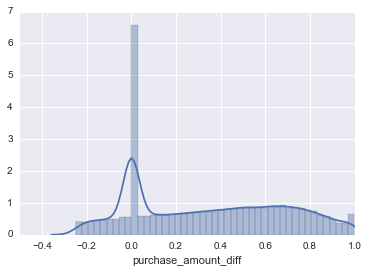

In [42]:
jobs_pip['purchase_amount_diff'] = jobs_pip.transpose().apply(lambda x: (x.purchase_price + x.amount) / x.purchase_price)
sns.distplot(jobs_pip.purchase_amount_diff, kde=True).set(xlim=(-.5, 1))
jobs_pip.purchase_amount_diff.describe()

# If we examine the KDE line above one can observe the multi-modal nature of the distribution.  
If we want to isolate the distribution surronding 0 we will invariably pick up some cases from the second and incorrect distribution.  We can assine a probability of correctness by examining the z-score.  However, at this time I will not begin a probabalistic model and will simple split the distributions at 0.2.

jobs_pip.shape:  (38764, 23)


//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



count    38764.000000
mean        -0.004088
std          0.098040
min         -0.250000
25%         -0.030601
50%          0.000000
75%          0.033613
max          0.200000
Name: purchase_amount_diff, dtype: float64

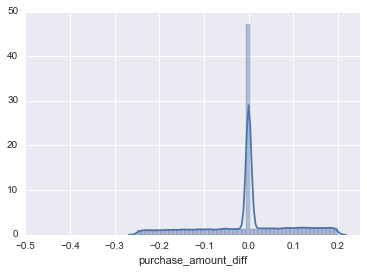

In [43]:
jobs_pip = jobs_pip[jobs_pip.purchase_amount_diff < 0.2]
sns.distplot(jobs_pip.purchase_amount_diff, kde=True).set(xlim=(-.5, .25))
print ('jobs_pip.shape: ', jobs_pip.shape)
jobs_pip.purchase_amount_diff.describe()

# We are still high by a factor of 2
Let's group by job_uuid and see if we can tell what differences.  It looks like the purchase_amount_diff is 0 for many of these.  If a job_uuid is matched with a transaction where the purchase_amount_diff is 0, let's assume they are a match.

In [45]:
jobs_pip_match = jobs_pip[jobs_pip.purchase_amount_diff == 0]
jobs_pip_match.shape

(15952, 23)

# Make a list of all the jobs for which we do not have ambiguity at this point

In [46]:
jobs_pip_grp = jobs_pip_match.groupby(by='job_uuid').count().reset_index()
jobs_pip_grp = jobs_pip_grp[['job_uuid', 'date_created']]
jobs_pip_grp.columns = ['job_uuid', 'count']
jobs_pip_grp = jobs_pip_grp[jobs_pip_grp['count'] == 1]
jobs_pip_grp.shape

(15622, 2)

# Use above list to generate a set of transaction that does not contain duplicates
It will, of course, not be a comprehensive list

In [48]:
jobs_pip_bool = jobs_pip_match.job_uuid.isin(jobs_pip_grp.job_uuid) 
jobs_pip_sub = jobs_pip_match[jobs_pip_bool]
print ('jobs_pip_sub.shape: ', jobs_pip_sub.shape)
jobs_pip_sub.head(n=2)

jobs_pip_sub.shape:  (15622, 23)


,job_uuid,date_created,courier_uuid,purchase_price,pip_account_id,business_name,street_address_1,street_address_2,city,state,...,transaction_id,transaction_dt,category,description,amount,transaction_code,pip_epoch,0_y,sim,purchase_amount_diff
122,fb86438f-8952-4398-8e5c-f509338f1851,2015-11-03 01:38:14.457542,1da6fc9d-b192-46a6-971a-429d94ac333c,49.32,8363.0,Fish Grill Restaurant,9618 W Pico Blvd,NaN,Los Angeles,CA,...,4440375.0,2015-11-03 01:55:04,Restaurants,"FISH GRILL, LOS ANGELES, CA",-49.32,1300.0,1.446534e+09,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0.0
185,eff38a8e-6b32-477c-9515-7f698c242048,2015-11-03 01:58:25.297675,1da6fc9d-b192-46a6-971a-429d94ac333c,7.20,8363.0,Starbucks,9718 Washington Blvd,NaN,Culver City,CA,...,4443152.0,2015-11-03 02:25:42,Restaurants,"STARBUCKS #05758 BEVERLY, Beverly Hills, CA",-7.20,1300.0,1.446536e+09,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",1,0.0


# Verify you don't have duplicates in the subset

In [49]:
jobs_pip_grp = jobs_pip_sub.groupby(by='job_uuid').count().reset_index()
jobs_pip_grp.date_created.max()

1

# What does the remaining set look like?

In [50]:
# We stil have a bunch of dups in the full set, right?
jobs_pip_grp = jobs_pip.groupby(by='job_uuid').count().reset_index()
jobs_pip_grp.date_created.max()

14

In [85]:
jobs_pip_potential_issues = jobs_pip[~jobs_pip.job_uuid.isin(jobs_pip_sub.job_uuid)]
jobs_pip_potential_issues.shape

(4668, 23)

In [86]:
jobs_pip_potential_issues.describe()

,purchase_price,pip_account_id,job_epoch,transaction_id,amount,transaction_code,pip_epoch,sim,purchase_amount_diff
count,4668.000000,4668.000000,4.668000e+03,4.668000e+03,4668.000000,4668.0,4.668000e+03,4668.000000,4668.000000
mean,25.457725,78777.993145,1.447001e+09,4.556536e+06,-25.359938,1300.0,1.447035e+09,0.038989,-0.004923
std,22.403027,27176.800375,3.594875e+05,8.933763e+04,21.300511,0.0,3.596821e+05,0.235532,0.121170
min,2.250000,8363.000000,1.446350e+09,4.379187e+06,-774.160000,1300.0,1.446353e+09,0.000000,-0.250000
25%,14.170000,57945.000000,1.446772e+09,4.491512e+06,-30.520000,1300.0,1.446798e+09,0.000000,-0.099109
50%,20.680000,87026.000000,1.446970e+09,4.548747e+06,-20.620000,1300.0,1.447021e+09,0.000000,0.000000
75%,30.520000,99963.000000,1.447307e+09,4.629394e+06,-14.120000,1300.0,1.447324e+09,0.000000,0.093598
max,888.310000,122988.000000,1.447650e+09,4.815140e+06,-2.450000,1300.0,1.447650e+09,4.000000,0.200000


In [87]:
jobs_pip_grp = jobs_pip_potential_issues.groupby(by='job_uuid').max().reset_index()
jobs_pip_grp = jobs_pip_grp[['job_uuid', 'sim']]
jobs_pip_grp.columns = ['job_uuid', 'max_sim']
jobs_pip_grp.head(n=1)

,job_uuid,max_sim
0,003b4782-6667-4d3a-ab2c-9a4460a00946,0


In [68]:
jobs_pip_potential_issues = pd.merge(jobs_pip_potential_issues, jobs_pip_grp)
print (jobs_pip_potential_issues.shape)
jobs_pip_potential_issues = jobs_pip_potential_issues[jobs_pip_potential_issues.sim == jobs_pip_potential_issues.max_sim]
jobs_pip_potential_issues.shape

(4668, 24)


(4459, 24)

In [88]:
jobs_pip_potential_issues2 = jobs_pip_potential_issues[jobs_pip_potential_issues.purchase_amount_diff < 0]
print (jobs_pip_potential_issues2.shape)
jobs_pip_potential_issues2.describe()

(2119, 23)


,purchase_price,pip_account_id,job_epoch,transaction_id,amount,transaction_code,pip_epoch,sim,purchase_amount_diff
count,2119.000000,2119.000000,2.119000e+03,2.119000e+03,2119.000000,2119.0,2.119000e+03,2119.000000,2119.000000
mean,24.133860,79859.873997,1.446995e+09,4.555297e+06,-26.779844,1300.0,1.447030e+09,0.035866,-0.114649
std,17.142428,26542.815855,3.623496e+05,9.027233e+04,18.646143,0.0,3.631691e+05,0.229210,0.073690
min,2.250000,8363.000000,1.446350e+09,4.379187e+06,-236.530000,1300.0,1.446354e+09,0.000000,-0.250000
25%,13.795000,61112.000000,1.446744e+09,4.490941e+06,-32.130000,1300.0,1.446780e+09,0.000000,-0.175173
50%,19.950000,87043.000000,1.446963e+09,4.544459e+06,-22.070000,1300.0,1.446983e+09,0.000000,-0.111737
75%,28.655000,100832.000000,1.447309e+09,4.629959e+06,-15.340000,1300.0,1.447330e+09,0.000000,-0.050000
max,233.780000,122988.000000,1.447650e+09,4.815140e+06,-2.450000,1300.0,1.447650e+09,4.000000,-0.000096


//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



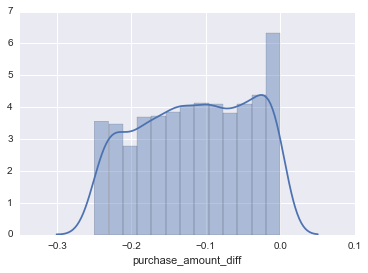

In [89]:
sns.distplot(jobs_pip_potential_issues2.purchase_amount_diff)

## Almost out of time, so this is getting sloppy.  I'm just going to say that anything under -0.15 is supicious.  That may be too conservative.

In [90]:
jobs_pip_potential_issues2 = jobs_pip_potential_issues2[jobs_pip_potential_issues2.purchase_amount_diff < -.15]
jobs_pip_potential_issues2.shape

(728, 23)

In [91]:
jobs_pip_potential_issues2['potential_losses'] = jobs_pip_potential_issues2.purchase_price + jobs_pip_potential_issues2.amount
jobs_pip_potential_issues2.potential_losses.sum()

-3232.3100000000013

# The above number is naive.  We should consider that only a portion of it will likely be monies in excess of the normal variation.  
But I'm out of time

## Clearly, I need to spend a few more hours cleaning this up.  There are many shortcomings.  Building the NLP features was probably a mistake.  It derailed me for maybe two hours.  The result is that it is likely that something greater that 0.5% of all expenditures are fraudulent. 

In [92]:
jobs_pip_potential_issues2.potential_losses.sum() / pip.amount.sum()

0.005902186592405548

# My output contains duplicates.  They are records I have yet to disambiguate

In [108]:
best_matches_with_duplicates = pd.concat([jobs_pip_sub,jobs_pip_potential_issues], axis=0)
output = best_matches_with_duplicates[['job_uuid', 'transaction_id']]
print (output.shape)
output.to_csv('job_transaction_matches.csv', index=False)

(20290, 2)


In [109]:
unmatched_transactions = pip[~pip.transaction_id.isin(best_matches.transaction_id)]
print (unmatched_transactions.shape)
unmatched_transactions[['transaction_id']].to_csv('unmatched_transactions.csv', index=False)

(2834, 9)


In [110]:
unmatched_jobs = jobs[~jobs.job_uuid.isin(best_matches.job_uuid)]
print (unmatched_jobs.shape)
unmatched_jobs[['job_uuid']].to_csv('unmatched_jobs.csv', index=False)

(1731, 13)
